In [1]:
import derpy 
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
plt.xkcd()

# Added to have access to the lab's functions for NKT laser control
import sys
sys.path.append("C:\\Users\\EPL User\\Desktop\\NKT_laser_control\\")
import os
import FliSdk_V2 as sdk  # As of now only Rayleigh has the First Light SDK installed. The camera is First Light CRED2 ER
from astropy.io import fits
import numpy as np
import time
from pylablib.devices import Thorlabs  # Library for controlling the Thorlabs rotation stages (holding the quarter-wave plates)
import copy
import os
from NKTcontrols.controls import compact, select, driver, get_status

Loading x64 DLL from: C:\Users\Public\Documents\NKT Photonics\SDK\NKTPDLL\x64\NKTPDLL.dll


# Initializing Camera Object

In [2]:
set_temperature = -40
fps = 10
tint = 20
temp_tolerance = 0.5

cam = derpy.CRED2(set_temperature=-40, fps=10, tint=90, temp_tolerance=0.5)

Updating...
Sensor Temperature: -40.01C
Motherboard Temperature: 38.25C
Frontend Temperature: 41.25C
Powerboard Temperature: 43.75C
Peltier Temperature: 14.11C
Heatsink Temperature: 38.0C
***********************
Sensor Temperature: -40.01C
Motherboard Temperature: 37.75C
Frontend Temperature: 41.0C
Powerboard Temperature: 43.75C
Peltier Temperature: 14.11C
Heatsink Temperature: 38.0C
***********************
Final Sensor Temperature -39.99C
Prior camera tint: 0.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962120.0999962

# Reworking Will's code to work with derpy

In [8]:
import os
import time
import numpy as np
from astropy.io import fits

# File Saving and Camera Settings
foldername_base = r"D:\\L_Plate_Characterization_12_23_2024\\x_3_y_6\\"   # Base folder
filename_string = "DRRP_JHK_Wavelength_Test_x_3_y_6_"

# Camera + Image Taking Settings
cam.set_temp = -40
num_images = 10

# Laser and Wavelength Settings
wavelengths = [1100, 1200, 1300, 1300, 1400, 1500, 1600, 1750, 1750, 1850, 1950]  # Ensure unique wavelengths
cam_tint_list = [99, 22, 3, 2, 1, 1, 1, 1, 2, 2, 3]  # Camera tint (ms) corresponding to each wavelength

# Ensure lengths of lists match
if len(cam_tint_list) != len(wavelengths):
    raise ValueError(f"Length of cam_tint_list ({len(cam_tint_list)}) does not match length of wavelengths ({len(wavelengths)}).")

cam_fps_list = [10] * len(wavelengths)  # Use plain Python list
overall_power_list = [100] * len(wavelengths)  # Use plain Python list
channel_power_list = [100] * len(wavelengths)  # Use plain Python list


# QWP Settings
tot_angle = 180
increment = 4
QWP2_ratio = 5

# Dark File Path
dark_file_dir = "C:\\Users\\EPL User\\Desktop\\desktop_drrp_data\\test_12_17_2024\\darks\\"

# Data Taking Script
compact1 = compact()
select1 = select()
driver1 = driver()

# Setup the laser
compact1.reset_interlock()
compact1.emission_on()

# Connect to motors
stage1 = Thorlabs.KinesisMotor(Thorlabs.list_kinesis_devices()[0][0], scale='stage')
stage2 = Thorlabs.KinesisMotor(Thorlabs.list_kinesis_devices()[1][0], scale='stage')
print("Connected to K10CR1 devices")

steps = int(tot_angle) / int(increment)

# Home the devices
print("Homing devices...")
stage1.move_to(0)
stage1.wait_move()
stage1._setup_homing()
home1 = stage1.home(sync=True)

stage2.move_to(0)
stage2.wait_move()
stage2._setup_homing()
home2 = stage2.home(sync=True)
print('Homing complete')

# Loop through steps and wavelengths
for i in range(int(steps) + 1):
    try:
        # Move the quarter waveplates to the next position to take more images
        angle = i * int(increment)
        commanded_position1 = angle
        commanded_position2 = QWP2_ratio * angle
        stage1.move_to(commanded_position1)
        stage1.wait_move()
        stage2.move_to(commanded_position2)
        stage2.wait_move()
        print(f"Commanded positions: {commanded_position1}, {commanded_position2} degrees")

        for idx, wavelength in enumerate(wavelengths):
            
            # Set laser and camera settings based on wavelength index
            cam.fps = cam_fps_list[idx]
            cam.tint = cam_tint_list[idx]
            compact1.overall_power(overall_power_list[idx])
            driver1.set_channel(1, wavelength, channel_power_list[idx])

            # Check for dark file
            dark_file_path = os.path.join(dark_file_dir, f"{int(cam.set_temp)}C_tint_{int(cam.tint)}_FPS_{int(cam.fps)}.fits")
            if not os.path.exists(dark_file_path):
                print(f"WARNING: Dark file does not exist at {dark_file_path}")
                continue  # Skip this iteration if dark file is missing

            # Save data for this wavelength
            foldername = os.path.join(foldername_base, f"Cal_{wavelength}_Raw\\")
            os.makedirs(foldername, exist_ok=True)

            image16b = cam.take_median_image(num_images)
            time.sleep(1.3 * cam.tint / 1000)
            print("Image shape =", image16b.shape)
            hdu_new = fits.PrimaryHDU(image16b)
            filename = f"{filename_string}{wavelength}nm_FPS_{int(cam.fps)}_tint_{int(cam.tint)}_QWP1_position_{int(commanded_position1)}_QWP2_position_{int(commanded_position2)}"
            hdu_new.writeto(os.path.join(foldername, filename + ".fits"), overwrite=True)

            # Add comments to FITS file header
            with fits.open(os.path.join(foldername, filename + '.fits'), mode='update') as hdu:
                header = hdu[0].header
                header['COMMENT1'] = "Raw image taken using CRED2 ER performing DRRP measurements."
                header['COMMENT2'] = f"QWP1 position: {commanded_position1} degrees. QWP2 position: {commanded_position2} degrees."
                header['COMMENT3'] = f"Camera temperature: {cam.set_temp}C. Framerate: {cam.fps}fps. Exposure time: {cam.tint}ms."
                hdu.flush()
            print(f"Files saved to {foldername}")
    except Exception as e:
        print(f"Error during processing step {i}: {e}")

print("Raw images taken")

# Reduce images
print("Reducing images...")
for idx, wavelength in enumerate(wavelengths):
    try:
        foldername = os.path.join(foldername_base, f"Cal_{wavelength}_Raw\\")
        new_directory = os.path.join(foldername_base, f"Cal_{wavelength}_Reduced\\")
        os.makedirs(new_directory, exist_ok=True)

        # Open the dark image
        dark = fits.getdata(dark_file_path)

        # Search through raw data folder
        for file in os.listdir(foldername):
            if file.startswith("DRRP_"):
                with fits.open(os.path.join(foldername, file)) as hdul:
                    img_data = hdul[0].data
                    reduced_data = img_data - dark

                # Save the reduced image
                new_filename = f"Reduced_{file}"
                fits.writeto(os.path.join(new_directory, new_filename), reduced_data, overwrite=True)

                # Add comments to reduced image header
                with fits.open(os.path.join(new_directory, new_filename), mode='update') as hdu:
                    header = hdu[0].header
                    header['COMMENT1'] = "Reduced image taken using CRED2 ER performing DRRP measurements."
                    header['COMMENT2'] = f"Camera temperature: {cam.set_temp}C. Framerate: {cam.fps}fps. Exposure time: {cam.tint}ms."
                    hdu.flush()

        print(f"Images have been reduced for wavelength {wavelength}. Process finished.")
    except Exception as e:
        print(f"Error during reduction for wavelength {wavelength}: {e}")


Interlock is OK.
Setting emission ON.
Connected to K10CR1 devices
Homing devices...
Homing complete
Commanded positions: 0, 0 degrees
Prior camera tint: 0.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.099996761

Block for closing Kinesis cage rotator connections

In [7]:
stage1.close()
stage2.close()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [18]:
hdu.close()

# Testing brightness of rightmost spot at all QWP1 angles

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.


DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_0_QWP2_position_0.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_100_QWP2_position_500.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_104_QWP2_position_520.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_108_QWP2_position_540.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_112_QWP2_position_560.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_116_QWP2_position_580.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_120_QWP2_position_600.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_124_QWP2_position_620.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_128_QWP2_position_640.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_12_QWP2_position_60.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP1_position_132_QWP2_position_660.fits
DRRP_JHK_Middle_Position_1950nm_FPS_10_tint_3_QWP

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

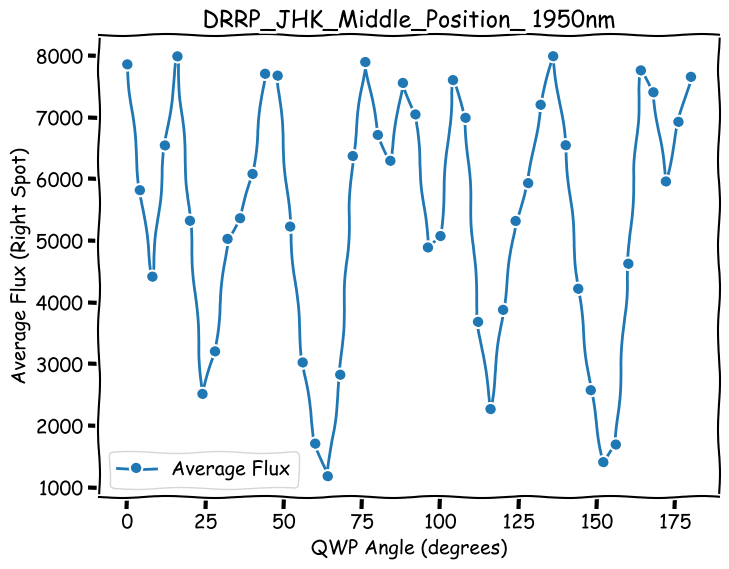

In [19]:
import os
import re
import numpy as np
from astropy.io import fits
from photutils.aperture import CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

# Define the file path
path = foldername

# Initialize lists to store results
average_fluxes = []
qwp_angles = []

# Loop through files in the directory
for filename in os.listdir(path):
    if filename.endswith('.fits'):
        print(filename)
        filepath = os.path.join(path, filename)
        
        # Extract QWP angle from the filename using regex
        match = re.search(r"_QWP1_position_(\d+)_", filename)
        if match:
            qwp_angle = float(match.group(1))  # Convert to float for plotting
            
            # Open the FITS file
            with fits.open(filepath) as hdul:
                data = hdul[0].data
            
            # Perform aperture photometry
            # Convert DS9 coordinates to Python indexing
            x, y = 390, 200  # DS9 is 1-based, Python is 0-based
            radius = 50
            aperture = CircularAperture((x, y), r=radius)
            phot_table = aperture_photometry(data, aperture)
            
            # Calculate average flux
            total_flux = phot_table['aperture_sum'][0]
            aperture_area = np.pi * radius**2
            average_flux = total_flux / aperture_area
            
            # Store the results
            average_fluxes.append(average_flux)
            qwp_angles.append(qwp_angle)

# Sort results by QWP angles
sorted_data = sorted(zip(qwp_angles, average_fluxes))
sorted_qwp_angles, sorted_average_fluxes = zip(*sorted_data)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(sorted_qwp_angles, sorted_average_fluxes, 'o-', label='Average Flux')
plt.xlabel('QWP Angle (degrees)')
plt.ylabel('Average Flux (Right Spot)')
plt.title(filename_string +  " " + str(wavelength) + "nm")
plt.grid()
plt.legend()
plt.show()


In [14]:
print(brightnesses)

[37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016, 37028500.25436016]
